# Word2vec basic implementation

See https://www.tensorflow.org/tutorials/word2vec
And https://www.github.com/tensorflow/tensorflow/blob/r1.1/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
for further details

In [11]:
import collections
import math
import os
import random
import zipfile

import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Read the data into a list of strings.

In [12]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    
    return data

### Build the dictionary and replace rare words with UNK token.

In [13]:
def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1

        data.append(index)

    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return data, count, dictionary, reverse_dictionary

### Function to generate a training batch for the skip-gram model.

In [14]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index

    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

Load the data in a usable form and print some statistics

In [15]:
filename = 'text8.zip'
words = read_data(filename)
print('Data size', len(words))
vocabulary_size = 50000

data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Data size 17005207
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5240, 3084, 12, 6, 195, 2, 3136, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [16]:
data_index = 0
batch_size = 128 # Size of each mini batch
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.
num_steps = 100001 # Number of training steps

## Define the computational graph

In [17]:
graph = tf.Graph() # Explicitly create a graph

with graph.as_default(): # Set it as default
    # Input data
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        # Hidden layer
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        # Output layer
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
        loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

        # Construct the SGD optimizer using a learning rate of 1.0.
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

        # Compute the cosine similarity between minibatch examples and all embeddings.
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
        similarity = tf.matmul(
            valid_embeddings, normalized_embeddings, transpose_b=True)

        # Add variable initializer.
        init = tf.global_variables_initializer()

### Train the model

In [18]:
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print("Average loss at step ", step, ": ", average_loss)
                average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Initialized
Nearest to can: sharkey, pnp, cim, raaf, pomegranate, barra, inlets, godwin,
Nearest to be: elfin, adverb, idiopathic, transverse, regretted, modafinil, switch, niccol,
Nearest to who: bigcup, relations, emptied, citrate, hardship, speedy, gain, fahrenheit,
Nearest to war: pmrc, sync, naturalists, cantata, thrice, dianetic, redemptive, gurps,
Nearest to their: devoutly, humans, italic, feats, designing, whittaker, abandons, repudiate,
Nearest to used: inelastic, acclamation, nasser, sequencing, parasites, fianc, artemisia, geese,
Nearest to when: darrell, sixtus, recognizes, standalone, brin, cavalrymen, afraid, tart,
Nearest to for: vocally, galway, barefoot, bourgeoisie, misuse, malls, liturgical, stwa,
Nearest to system: tanks, citeseer, remedies, bourdieu, zebulon, inhibiting, zoltan, maud,
Nearest to also: lightened, citeseer, enchanter, milgrom, witted, ishaq, sacco, lava,
Nearest to by: hanyu, betrayed, avery, perkins, financier, nintendo, connectionless, chauffeur,


Average loss at step  52000 :  5.03429563689
Average loss at step  54000 :  5.18880750251
Average loss at step  56000 :  5.03773003304
Average loss at step  58000 :  5.03172216022
Average loss at step  60000 :  4.94046228325
Nearest to can: will, would, may, could, must, should, lnot, operatorname,
Nearest to be: have, been, was, by, were, is, are, being,
Nearest to who: he, which, also, there, they, never, primigenius, that,
Nearest to war: agouti, flightless, supplier, captain, visibly, naturalists, rice, liberal,
Nearest to their: his, its, the, her, dasyprocta, abort, atemi, ursus,
Nearest to used: possible, nasser, anthropic, save, albury, held, arise, swell,
Nearest to when: after, six, before, however, then, as, four, but,
Nearest to for: after, or, of, in, abet, with, to, as,
Nearest to system: tanks, remedies, licenses, inhibiting, general, agrees, differentiation, laser,
Nearest to also: which, often, never, not, there, fairs, who, that,
Nearest to by: was, with, five, be, fr

### tSNE Visualization

In [19]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500 # Plot only 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plt.figure(figsize=(18, 18))  # in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.savefig("tSNE.png")
#plt.show()

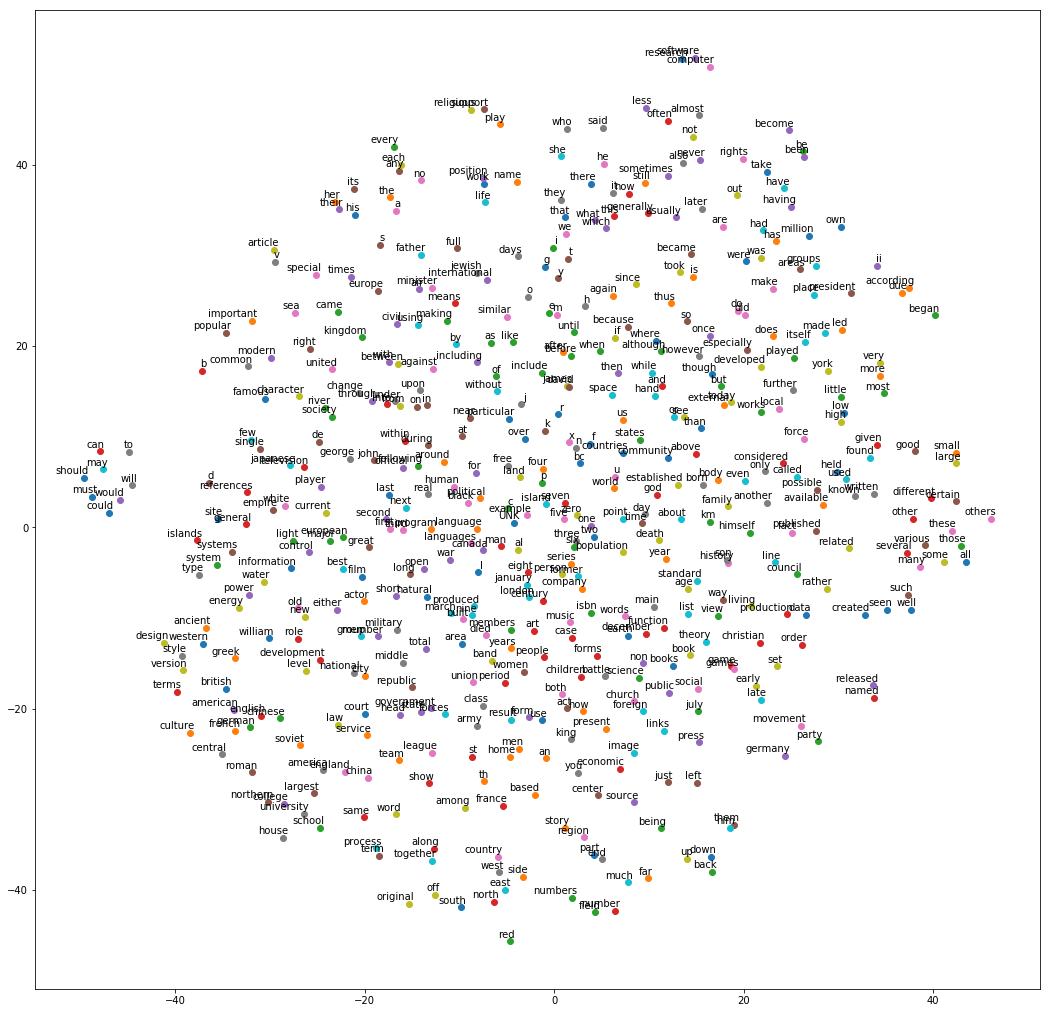

In [20]:
plt.show()